# Imports e  Constantes



In [7]:
import pygame
import random
import requests
import cv2
import numpy as np
#from google.colab.patches import cv2_imshow
#from google.colab import output
import time
import pickle
import os, sys
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
# set SDL to use the dummy NULL video driver,
#   so it doesn't need a windowing system.
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [9]:
# Constants for the game grid
GRID_SIZE = 40
GRID_WIDTH = 10
GRID_HEIGHT = 10

# Define actions
ACTIONS = [(0, -1), (0, 1), (-1, 0), (1, 0)]  # Up, Down, Left, Right

# Colors
WHITE = (255, 255, 255)
GREEN = (0, 255, 0)
RED = (255, 0, 0)
BLUE = (0, 0, 255)  # Color for the snake's head


#Ambiente e Agente

In [10]:
class SnakeGame():
    def __init__(self, delay_time = 0.000005):
        pygame.init()
        self.screen = pygame.display.set_mode((GRID_WIDTH * GRID_SIZE, GRID_HEIGHT * GRID_SIZE))
        pygame.display.set_caption("Snake Game - RL")
        self.delay_time = delay_time
        self.reset()

    def get_state(self):
      s = self.snake[0]
      f = self.food

      state_x = s[0] - f[0]
      state_y = s[1] - f[1]

      return (state_x, state_y)

    def reset(self):
        self.food = self.initialize_food()
        self.snake = self.initialize_snake(food = self.food)

    def initialize_food(self):
        empty_cells = [(x, y) for x in range(GRID_WIDTH) for y in range(GRID_HEIGHT)]
        return random.choice(empty_cells)

    def initialize_snake(self, food):
        empty_cells = [(x, y) for x in range(GRID_WIDTH) for y in range(GRID_HEIGHT)]
        empty_cells.remove(food)
        return [random.choice(empty_cells)]

    def is_valid_move(self, action):
        new_head = (self.snake[0][0] + action[0], self.snake[0][1] + action[1])
        #print("new_head[0]", new_head[0] < 0)
        #print("new_head[0]", new_head[0] >= GRID_WIDTH)
        #print("new_head[1]", new_head[1] < 0)
        #print("new_head[1]", new_head[1] >= GRID_HEIGHT)
        #print("new_head in ", new_head in self.snake) # erro esta aqui
        if (
            new_head[0] < 0
            or new_head[0] >= GRID_WIDTH
            or new_head[1] < 0
            or new_head[1] >= GRID_HEIGHT
            or new_head in self.snake
        ):
            return False

        return True

    def step(self, reward_shape, method = 'random', value_function = None, N0 = 1, N = 1,
             test_only = False, stochastic = False, stochastic_level = 0.9):

      reward = 0
      get = False
      # valid_actions = [action for action in ACTIONS if self.is_valid_move(action)]
      # action = random.choice(ACTIONS)
      action = self.get_desired_action(method = method, value_function = value_function, N0 = N0, N = N, test_only = test_only)
      is_valid = self.is_valid_move(action)
      while not is_valid:
          #print("Nao e valido")
          action = self.get_desired_action(method = 'random', value_function = value_function, N0 = N0, N = N, test_only = test_only)
          reward = reward_shape[0]
          is_valid = self.is_valid_move(action)
          #return reward, True  # No reward and episode ends
      #print("Action Selected", action)
      if self.snake[0] == self.food:
          self.food = self.initialize_food()
          self.snake.append((0, 0))
          reward = reward_shape[1]
          get = True
      else:
          reward = reward_shape[0]
      #elif action != self.get_desired_action():
      #    reward = reward_shape[0]

      if stochastic == 'all': #se todo tabuleiro é estocastico
        if np.random.uniform(0,1,1)[0] < stochastic_level: #o com essa probabilidade, uma ação aleatoria é tomada

          action = self.get_desired_action(method = 'random', value_function = value_function, N0 = N0, N = N, test_only = test_only)
          is_valid = self.is_valid_move(action)
          while not is_valid:
              #print("Nao e valido")
              action = self.get_desired_action(method = 'random', value_function = value_function, N0 = N0, N = N, test_only = test_only)
              reward = reward_shape[0]
              is_valid = self.is_valid_move(action)


      if stochastic == 'up': #se a parte de cima do tabuleiro é estocastico

        if self.snake[0][0] <=4:
          if np.random.uniform(0,1,1)[0] < stochastic_level: #o com essa probabilidade, uma ação aleatoria é tomada

            action = self.get_desired_action(method = 'random', value_function = value_function, N0 = N0, N = N, test_only = test_only)
            is_valid = self.is_valid_move(action)
            while not is_valid:
                #print("Nao e valido")
                action = self.get_desired_action(method = 'random', value_function = value_function, N0 = N0, N = N, test_only = test_only)
                reward = reward_shape[0]
                is_valid = self.is_valid_move(action)


      if stochastic == 'type2': #se a parte de cima do tabuleiro é estocastico

        state = self.get_state()

        if state[0] == 0 or state[1] == 0: #se estiver na mesma "reta" que a fruta
          if np.random.uniform(0,1,1)[0] < stochastic_level: #o com essa probabilidade, uma ação aleatoria é tomada

            action = self.get_desired_action(method = 'random', value_function = value_function, N0 = N0, N = N, test_only = test_only)
            is_valid = self.is_valid_move(action)
            while not is_valid:
                #print("Nao e valido")
                action = self.get_desired_action(method = 'random', value_function = value_function, N0 = N0, N = N, test_only = test_only)
                reward = reward_shape[0]
                is_valid = self.is_valid_move(action)

      new_head = (self.snake[0][0] + action[0], self.snake[0][1] + action[1])

      self.snake.insert(0, new_head)
      self.snake.pop()

      return reward, True, get, action


    def step_q(self, action):
      new_head = (self.snake[0][0] + action[0], self.snake[0][1] + action[1])

      if (new_head in self.snake) or (new_head[0] < 0 or new_head[0] >= GRID_WIDTH or new_head[1] < 0 or new_head[1] >= GRID_HEIGHT):
          return -10, self.get_state(), True # Game Over

      if new_head == self.food:
          self.snake.insert(0, new_head)
          self.food = self.initialize_food()
          return 10, self.get_state(), False


      self.snake.insert(0, new_head)
      self.snake.pop()


      distance_to_food = abs(new_head[0] - self.food[0]) + abs(new_head[1] - self.food[1])
      reward = -distance_to_food

      return reward, self.get_state(), False  # Return reward, new state, and False for game not over



    def render(self, render = True):

        if not render:
          return None

        self.screen.fill(WHITE)
        for i, segment in enumerate(self.snake):
            if i == 0:
                pygame.draw.rect(self.screen, BLUE, (segment[0] * GRID_SIZE, segment[1] * GRID_SIZE, GRID_SIZE, GRID_SIZE))
            else:
                pygame.draw.rect(self.screen, GREEN, (segment[0] * GRID_SIZE, segment[1] * GRID_SIZE, GRID_SIZE, GRID_SIZE))
        pygame.draw.rect(self.screen, RED, (self.food[0] * GRID_SIZE, self.food[1] * GRID_SIZE, GRID_SIZE, GRID_SIZE))
        pygame.display.update()

        #to run in Colab:
        #convert image so it can be displayed in OpenCV
        view = pygame.surfarray.array3d(self.screen)
        img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)
        cv2_imshow(img_bgr)
        time.sleep(self.delay_time)
        output.clear()

    # Optmization that make snake go only to the direction of the food, instead of choosing a random direction
    def get_desired_action(self, method = 'random', value_function = None, N0 = 1, N = 1, test_only = False):
        head = self.snake[0]
        food = self.food
        delta_x = food[0] - head[0]
        delta_y = food[1] - head[1]


        if method == 'best':
          if delta_x > 0:
              return (1, 0)  # Right
          elif delta_x < 0:
              return (-1, 0)  # Left
          elif delta_y > 0:
              return (0, 1)  # Down
          elif delta_y < 0:
              return (0, -1)  # Up
          else:
              return (0, 0)  # No movement


        #choose a random action
        if method  == 'random':
          possible_actions = [(1,0), (-1,0), (0,1),(0,-1)]
          idx = np.random.choice([0,1,2,3])
          return possible_actions[idx]

        if method == 'value':
          #print(N0)
          epsilon = N0/(N0+N)

          if test_only:
            epsilon = 0.01

          if np.random.uniform(0,1,1)[0] < epsilon:
            possible_actions = [(1,0), (-1,0), (0,1),(0,-1)]
            idx = np.random.choice([0,1,2,3])
            return possible_actions[idx]

          state = self.get_state()
          possible_actions = [(1,0), (-1,0), (0,1),(0,-1)]
          max_value = -np.inf
          for a in possible_actions:

            future_state = (state[0] + a[0], state[1] +a[1])
            if self.is_valid_move(a):
              #print(future_state,state,  self.snake, self.food, value_function[str(future_state)])
              if value_function[str(future_state)] >= max_value:
                f = future_state
                v = value_function[str(future_state)]
                max_value = value_function[str(future_state)]
                action = a

          #print('--', v, f, action)
          return action



In [65]:
class RL_Agent():
    def __init__(self, game, alpha=0.1, gamma=0.9, epsilon=1.0, decay=0.995):
        self.game = game
        self.q_table = {}  # Initialize Q-table, dict of tuples
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.decay = decay
        self.decision_explore_exploit = []
        self.step_per_episode = []
        # duplicando Q só pra não termos nenhum possível problema (testar depois)
        self.value_function = self.create_value_function()

    def get_q_value(self, state, action):
        return self.q_table.get((state, action), 0)

    def choose_action(self, state):
        # Explore or exploit
        if np.random.rand() < self.epsilon:
            self.decision_explore_exploit.append(0) # Eploring
            return random.choice(ACTIONS)
        else:
            self.decision_explore_exploit.append(1) # Exploiting
            q_values = [self.get_q_value(state, a) for a in ACTIONS]
            max_q = max(q_values)
            actions_with_max_q = [a for a in ACTIONS if self.get_q_value(state, a) == max_q]
            return random.choice(actions_with_max_q)
        
    def create_value_function(self):
      global GRID_HEIGHT
      global GRID_WIDTH
      value = {}

      for x in range(-GRID_WIDTH+1, GRID_WIDTH):
        for y in range(-GRID_HEIGHT+1, GRID_HEIGHT):

          value[f'({x}, {y})'] = 0

      value[str((0,0))] = np.inf #pois esse é estado final e o que mais vale
      return value

    def train(self, episodes, sarsa):
        for episode in range(episodes):
          #print(episode)
          #print(f"Current Episode: {episode}")
          self.game.reset()
          state = self.game.get_state()
          done = False
          counter = 0
          while not done:
              counter += 1
              action = self.choose_action(state)
              reward, next_state, done = self.game.step_q(action)
              if sarsa == True:
                  # after getting the new state, I need to compute ne next action
                  next_action = self.choose_action(next_state)
                  self.update_q_table(state, action, reward, next_state, next_action)
                  #print('entrei no sarsa')
              else:
                self.update_q_table(state, action, reward, next_state)
                #print('entrei no qlearning')
              state = next_state
         # print("Number of Steps", counter)
          self.step_per_episode.append(counter)
          self.epsilon *= self.decay
          #print(f"Current table: {self.q_table}")

    def run_episode(self, sarsa): #to test a trained agent

      self.epsilon = 0 #to test the policy, without random effects

      self.game.reset()
      state = self.game.get_state()
      done = False
      ep_len = 0

      while not done:
          ep_len += 1
          action = self.choose_action(state)
          reward, next_state, done = self.game.step_q(action)
          if sarsa == True:
                # after getting the new state, I need to compute ne next action
                next_action = self.choose_action(next_state)
                self.update_q_table(state, action, reward, next_state, next_action)
                #print('entrei no sarsa')
          else:
                self.update_q_table(state, action, reward, next_state)
                #print('entrei no qlearning')
          state = next_state

      return ep_len
    
class QLearning(RL_Agent):

    def update_q_table(self, state, action, reward, next_state):
        max_q_next = max([self.get_q_value(next_state, a) for a in ACTIONS])
        current_q = self.get_q_value(state, action)
        new_q = current_q + self.alpha * (reward + self.gamma * max_q_next - current_q)
        self.q_table[(state, action)] = new_q
        self.value_function[str(state)] = new_q
        
class Sarsa(RL_Agent):
    
    def update_q_table(self, state, action, reward, next_state, next_action):
        #max_q_next = max([self.get_q_value(next_state, a) for a in ACTIONS])
        current_q = self.get_q_value(state, action)
        if current_q is None:
            # tive uns erros se não inicializasse algum valor para um Q não visto
            self.q_table[(state, action)] = reward
        else:
            new_q = self.get_q_value(next_state, next_action)
            self.q_table[(state, action)] = current_q + self.alpha * (reward + self.gamma * new_q - current_q)
            self.value_function[str(state)] = current_q + self.alpha * (reward + self.gamma * new_q - current_q)

# Testando o método Sarsa

In [48]:
def test_sarsa(agent_sarsa, n_iter = 1000):
  ep_len_total = 0
  loop = 0
  for i in range(n_iter):

    ep_len = agent_sarsa.run_episode(True)
    ep_len_total +=  ep_len

    if ep_len>=999:
      loop+=1

  ep_len_mean = ep_len_total/n_iter
  prop_loop = loop/n_iter

  return ep_len_mean, prop_loop

In [49]:
game_1 = SnakeGame()
agent_sarsa = Sarsa(game_1)
#sarsa=True
agent_sarsa.train(1000, True)

In [50]:
test_sarsa(agent_sarsa)

(10.159, 0.0)

In [51]:
# print("decision array per episode", q_learning.decision_explore_exploit)
print("Steps per episode", agent_sarsa.step_per_episode)
print("Min Steps", min(agent_sarsa.step_per_episode))
print("Max Steps", max(agent_sarsa.step_per_episode))
print("AVG Steps", sum(agent_sarsa.step_per_episode)/len(agent_sarsa.step_per_episode))
sarsa_df = pd.DataFrame.from_dict([agent_sarsa.q_table])
print(sarsa_df)

Steps per episode [87, 11, 1, 6, 56, 2, 6, 6, 15, 22, 1, 51, 31, 6, 2, 14, 29, 31, 48, 2, 6, 17, 38, 2, 6, 2, 1, 14, 44, 31, 7, 1, 11, 3, 43, 1, 10, 2, 1, 16, 15, 24, 5, 13, 2, 16, 39, 17, 12, 35, 7, 2, 5, 2, 3, 11, 13, 5, 4, 1, 15, 6, 7, 4, 3, 4, 6, 18, 3, 46, 1, 16, 14, 23, 12, 18, 27, 30, 32, 25, 12, 6, 78, 79, 1, 4, 1, 7, 4, 10, 4, 19, 32, 21, 4, 4, 4, 6, 4, 2, 6, 4, 19, 15, 77, 10, 5, 1, 19, 4, 16, 16, 13, 19, 23, 19, 4, 4, 5, 14, 18, 5, 12, 7, 6, 17, 17, 1, 2, 1, 2, 16, 15, 17, 7, 3, 9, 6, 2, 1, 5, 10, 11, 35, 51, 37, 22, 50, 11, 3, 20, 7, 14, 4, 14, 1, 3, 61, 4, 1, 2, 5, 29, 40, 3, 4, 7, 36, 3, 5, 1, 3, 50, 40, 2, 1, 39, 12, 23, 10, 28, 23, 7, 2, 11, 33, 31, 3, 17, 48, 17, 9, 17, 18, 8, 23, 11, 1, 5, 13, 5, 22, 21, 33, 11, 6, 47, 1, 2, 3, 4, 3, 4, 1, 14, 1, 17, 12, 10, 9, 21, 10, 35, 11, 1, 31, 1, 32, 19, 1, 31, 61, 1, 6, 10, 59, 14, 7, 1, 8, 12, 12, 24, 4, 11, 6, 1, 2, 7, 5, 2, 8, 7, 6, 7, 10, 9, 2, 3, 21, 4, 4, 15, 1, 8, 17, 37, 21, 21, 2, 12, 1, 1, 29, 7, 8, 2, 24, 17, 6, 4, 

In [66]:
# testando com diferentes Ns 
import datetime

for i in [1000, 10000]:
   print('Rodando p/ i=', i)
   now = datetime.datetime.now()
   print('Start time: ', now)
   game_1 = SnakeGame()
   agent_sarsa = Sarsa(game_1)
   #sarsa=True
   agent_sarsa.train(i, True)
   end = datetime.datetime.now()
   print('Time elapsed: ', end-now)

   with open(f'q_values_sarsa_{i}runs.pkl', 'wb') as fp:
      pickle.dump(agent_sarsa.value_function, fp)
   

Rodando p/ i= 1000
Start time:  2023-11-28 08:57:23.015209
Time elapsed:  0:00:00.140842
Rodando p/ i= 10000
Start time:  2023-11-28 08:57:23.158738
Time elapsed:  0:00:01.424842


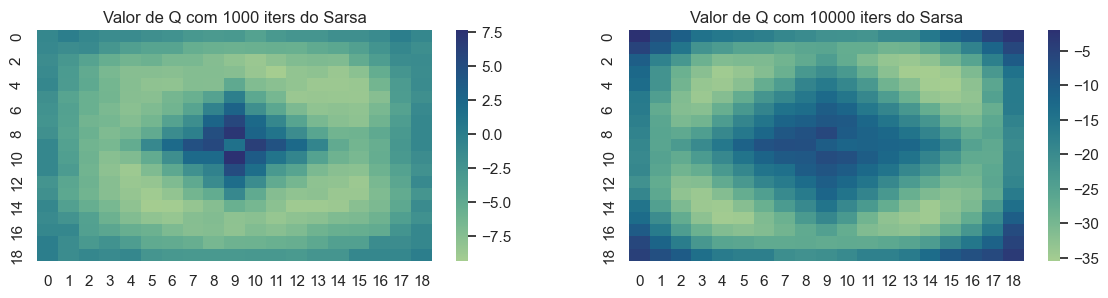

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(14, 3))
for i, n in enumerate([1000, 10000]):
  with open(f'q_values_sarsa_{n}runs.pkl', 'rb') as fp:
    value_function = pickle.load(fp)

  matrix_values = np.zeros((19, 19))
  #print(value_function.keys())
  for k in list(value_function.keys()):
    #print(k)
    x = int(k.split(',')[0].split('(')[1])
    y = int(k.split(',')[1].split(')')[0])

    matrix_values[x+9][y+9] = value_function[k]

  #matrix_values[19][19] = 0

  sns.heatmap(matrix_values, ax = axs[i], cmap="crest")#, annot = True)
  axs[i].set_title(f'Valor de Q com {n} iters do Sarsa')

### Testando o método Q-Learning

In [64]:
game_1 = SnakeGame()
agent_qlearning = QLearning(game_1)
sarsa=False
agent_qlearning.train(1000, False)

0
2
1
4
5
4
3
3
2
3
2
2
3
3
4
2
3
4
4
3
-1
4
6
5
-4
-4
-4
-4
-4
-4
-5
-6
-6
6
1
7
-4
-5
-4
-3
-4
-4
-4
-3
-3
-3
-4
-5
-5
-5
-4
-4
-4
-4
-5
-4
-5
-5
-5
-5
-5
-5
-4
-4
-4
-3
-3
-3
-4
-3
-4
-4
-3
-3
-3
-3
-3
-2
-3
-2
-3
-3
-4
-5
-5
-4
-5
-5
-4
-4
-4
-4
-4
-4
-4
-3
-3
-2
-3
-3
-3
-4
-3
-4
-4
-3
-3
-4
-4
-5
-5
-5
-4
-5
-5
-5
-4
-4
-5
8
3
2
3
3
2
1
1
0
9
0
-1
0
-1
-1
-1
0
1
1
1
0
0
0
-1
-2
-1
-1
-1
-2
-2
-1
-2
-2
-2
-3
-3
-3
-3
-2
-2
-2
-3
-4
-5
-5
-4
-3
-3
-4
-3
-2
10
1
1
2
1
2
2
1
3
11
4
3
4
4
12
5
4
5
13
0
-1
0
-1
14
4
4
4
4
15
1
2
2
3
3
3
2
1
2
2
1
2
3
2
1
1
0
-1
-1
0
1
1
2
3
3
3
4
5
16
2
1
2
3
3
3
4
3
3
17
0
0
18
-1
-1
0
1
2
2
2
1
2
19
-1
-2
-2
-2
-2
-3
20
5
5
5
5
5
5
21
1
0
-1
-1
-1
-1
-1
-1
0
1
1
0
1
1
1
1
1
2
2
2
2
2
3
2
22
0
-1
-2
-2
-1
0
0
1
1
1
1
1
1
1
2
2
2
3
4
5
4
4
3
3
3
3
3
4
4
3
3
3
3
4
4
5
5
6
6
6
5
5
5
23
-3
-3
-4
-5
24
4
4
5
4
3
2
3
25
5
6
5
4
3
2
3
3
4
5
26
-1
-1
0
0
1
0
1
1
2
1
1
0
1
2
1
2
2
2
2
2
2
2
1
2
2
2
3
27
3
28
-5
-5
-5
-5
-5
-5
-6
-5
-5
-5
-6
-6
-5
-6
29
-2
-2
-

In [41]:
def test_q_learning(agent_qlearning, n_iter = 1000):
  ep_len_total = 0
  loop = 0
  for i in range(n_iter):

    ep_len = agent_qlearning.run_episode(False)
    ep_len_total +=  ep_len

    if ep_len>=999:
      loop+=1

  ep_len_mean = ep_len_total/n_iter
  prop_loop = loop/n_iter

  return ep_len_mean, prop_loop

In [42]:
test_q_learning(agent_qlearning)

(10.16, 0.0)

In [45]:
# print("decision array per episode", q_learning.decision_explore_exploit)
print("Steps per episode", agent_qlearning.step_per_episode)
print("Min Steps", min(agent_qlearning.step_per_episode))
print("Max Steps", max(agent_qlearning.step_per_episode))
print("AVG Steps", sum(agent_qlearning.step_per_episode)/len(agent_qlearning.step_per_episode))
q_df = pd.DataFrame.from_dict([agent_qlearning.q_table])
print(q_df)

Steps per episode [2, 6, 4, 3, 81, 5, 2, 11, 27, 40, 6, 13, 2, 6, 6, 9, 14, 93, 4, 6, 2, 32, 36, 1, 16, 1, 3, 13, 22, 10, 1, 12, 16, 3, 20, 4, 3, 4, 67, 63, 31, 15, 25, 3, 18, 28, 7, 6, 78, 2, 18, 18, 3, 7, 10, 6, 31, 37, 18, 17, 3, 8, 15, 7, 6, 26, 48, 7, 8, 31, 4, 2, 4, 56, 8, 17, 11, 3, 21, 6, 5, 8, 2, 7, 3, 10, 3, 4, 30, 38, 2, 15, 36, 4, 2, 10, 12, 19, 3, 1, 3, 24, 5, 1, 13, 45, 2, 8, 37, 7, 4, 23, 13, 3, 5, 12, 7, 1, 12, 1, 3, 6, 16, 4, 40, 3, 9, 40, 2, 34, 45, 20, 1, 9, 29, 3, 2, 6, 26, 6, 9, 13, 4, 36, 10, 31, 16, 12, 14, 14, 49, 23, 5, 20, 2, 12, 21, 51, 51, 9, 4, 10, 22, 17, 25, 3, 2, 8, 4, 6, 9, 15, 20, 3, 27, 9, 14, 13, 10, 76, 11, 15, 19, 3, 18, 2, 11, 3, 10, 6, 9, 39, 9, 2, 35, 5, 8, 15, 15, 7, 18, 10, 1, 5, 3, 7, 13, 21, 44, 9, 8, 11, 4, 7, 11, 7, 2, 2, 11, 27, 1, 16, 4, 4, 7, 19, 3, 11, 32, 6, 12, 10, 13, 6, 6, 6, 3, 8, 8, 2, 46, 13, 33, 13, 5, 30, 15, 7, 1, 22, 11, 6, 15, 9, 2, 7, 11, 5, 36, 50, 3, 17, 19, 4, 10, 10, 9, 2, 11, 31, 8, 10, 9, 3, 1, 20, 2, 3, 24, 2, 14, 8

In [ ]:
game_1 = SnakeGame()
q_learning = QLearningAgent(game_1)
q_learning.train(5000)

In [ ]:
# print("decision array per episode", q_learning.decision_explore_exploit)
print("Steps per episode", q_learning.step_per_episode)
print("Min Steps", min(q_learning.step_per_episode))
print("Max Steps", max(q_learning.step_per_episode))
print("AVG Steps", sum(q_learning.step_per_episode)/len(q_learning.step_per_episode))
q_df = pd.DataFrame.from_dict([q_learning.q_table])
print(q_df)


In [68]:
# testando com diferentes Ns 
import datetime

for i in [1000, 10000]:
   print('Rodando p/ i=', i)
   now = datetime.datetime.now()
   print('Start time: ', now)
   game_1 = SnakeGame()
   agent_q = QLearning(game_1)
   #sarsa=True
   agent_q.train(i, False)
   end = datetime.datetime.now()
   print('Time elapsed: ', end-now)

   with open(f'q_values_qlearning_{i}runs.pkl', 'wb') as fp:
      pickle.dump(agent_q.value_function, fp)
   

Rodando p/ i= 1000
Start time:  2023-11-28 08:57:42.403854
Time elapsed:  0:00:00.133242
Rodando p/ i= 10000
Start time:  2023-11-28 08:57:42.538099
Time elapsed:  0:00:01.125468


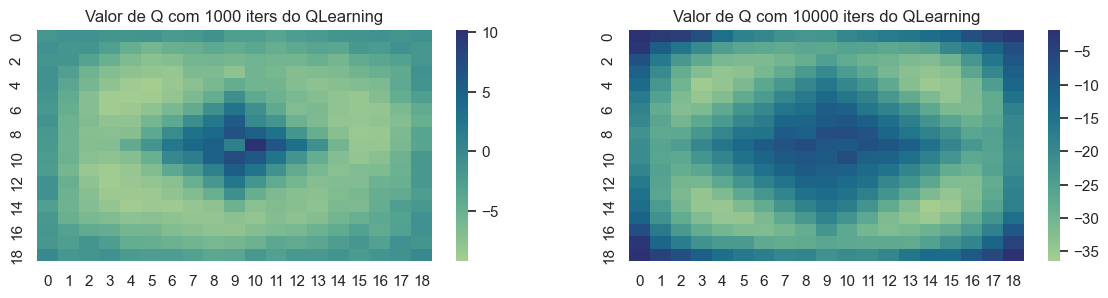

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(14, 3))
for i, n in enumerate([1000, 10000]):
  with open(f'q_values_qlearning_{n}runs.pkl', 'rb') as fp:
    value_function = pickle.load(fp)

  matrix_values = np.zeros((19, 19))
  #print(value_function.keys())
  for k in list(value_function.keys()):
    #print(k)
    x = int(k.split(',')[0].split('(')[1])
    y = int(k.split(',')[1].split(')')[0])

    matrix_values[x+9][y+9] = value_function[k]

  #matrix_values[19][19] = 0

  sns.heatmap(matrix_values, ax = axs[i], cmap="crest")#, annot = True)
  axs[i].set_title(f'Valor de Q com {n} iters do QLearning')

# Monte Carlo

In [8]:
class MonteCarloAgent():
    def __init__(self, game, gamma = 0.9, reward_shape = [-1, 99]):
        self.game = game
        self.V = {}
        self.gamma = gamma
        self.reward_shape = reward_shape
        self.value_function = self.create_value_function()
        self.states_count = self.create_states_count()
        self.states_and_actions = self.create_states_and_actions()

    def get_state(self):
      s = self.game.snake[0]
      f = self.game.food

      state_x = s[0] - f[0]
      state_y = s[1] - f[1]

      return (state_x, state_y)


    def state_to_str(self, state):
        return str(state)

    def create_value_function(self):
      global GRID_HEIGHT
      global GRID_WIDTH
      value = {}

      for x in range(-GRID_WIDTH+1, GRID_WIDTH):
        for y in range(-GRID_HEIGHT+1, GRID_HEIGHT):

          value[f'({x}, {y})'] = 0

      value[str((0,0))] = np.inf #pois esse é estado final e o que mais vale
      return value

    def create_states_count(self):
      global GRID_HEIGHT
      global GRID_WIDTH
      N = {}

      for x in range(-GRID_WIDTH+1, GRID_WIDTH):
        for y in range(-GRID_HEIGHT+1, GRID_HEIGHT):

          N[f'({x}, {y})'] = 0

      return N


    def create_states_and_actions(self):
      global GRID_HEIGHT
      global GRID_WIDTH
      N = {}

      for x in range(-GRID_WIDTH+1, GRID_WIDTH):
        for y in range(-GRID_HEIGHT+1, GRID_HEIGHT):

          N[f'({x}, {y})'] = {(1,0):0, (-1,0):0, (0,1):0, (0,-1):0 }
      return N

    def run_episode(self, method = 'random', alpha= 0.1, gamma = 0.9, test_only = False, render = False, N0 = 1, N = 1,
                    stochastic = False):

        episode_states = []
        episode_rewards = 0

        self.game.reset()
        get = False
        while not get:
            state = self.get_state()
            state_str = self.state_to_str(state)
            episode_states.append(state)

            self.states_count[state_str] = self.states_count[state_str]+1
            N = self.states_count[str(episode_states[0])]

            reward, done, get, action = self.game.step(self.reward_shape, method = method, N0 = N0, N = N,
                                               value_function = self.value_function, test_only = test_only, stochastic = stochastic)

            if len(episode_states) == 1:
              first_action = action

            self.game.render(render = render)
            episode_rewards += gamma**(len(episode_states)) * reward

            self.states_and_actions[state_str][action] = self.states_and_actions[state_str][action]+1


            if len(episode_states)>1000:
              #print('Loop =( Energia acabou...')
              break
            if not done:
                break

        if not test_only:
          v = self.value_function[str(episode_states[0])]
          alpha = 1/self.states_and_actions[str(episode_states[0])][first_action]
          self.value_function[str(episode_states[0])] = v + alpha*(episode_rewards - v)

        ep_len = len(episode_states)

        return ep_len

    def run_Monte_Carlo(self, num_samples = 1, alpha = 0.1, N0 = 0, N = 1, stochastic = False):

      for i in range(num_samples):
        self.run_episode(alpha = alpha, method = 'value', N0 = N0, N = N, stochastic = stochastic)

# Testes do Método de Monte Carlo

## Códigos e Funções

Abaixo estão listados os códigos que usamos para rodar esses experimentos. Isso pode demorar um pouco e por isso estão comentados. Os resultados serão exibidos na próxima seção.

In [9]:
#essa função é para medir diferentes abordagens,
#com ela podemos ver quantos passos em média cada politca demora para chegar no objetivo
#além disso, podemos ver a % de vezes que o jogo entra em loop, ou seja, masi de 1000 passos

def test_method(method, n_iter = 1000):
  ep_len_total = 0
  loop = 0
  for i in range(n_iter):

    ep_len = agent.run_episode(method = method, render = False, test_only = True)
    ep_len_total +=  ep_len

    if ep_len>=999:
      loop+=1

  ep_len_mean = ep_len_total/n_iter
  prop_loop = loop/n_iter

  return ep_len_mean, prop_loop

In [10]:
#criando o jogo e o agente monte carlo
game = SnakeGame()
game.render()
agent = MonteCarloAgent(game)

In [11]:
#fazendo um teste com a politica aleatoria
agent.run_episode(method = 'random', render = False)

286

In [12]:
# O código abaixo roda diferentes numeros de treinamentos
# Ele é responsável por tetsar o efeito da quantidade de treino
# Foi fixado um N0=1000 e um aplha dinâmico, como requisitado

# for i, r in enumerate([[0, 99]]):#[1000, 10000, 100000, 1000000]:
#   game = SnakeGame()
#   game.render()
#   agent = MonteCarloAgent(game, reward_shape = r)

#   agent.run_Monte_Carlo(num_samples = 100000, N0 = 100, stochastic=False)

#   with open(f'value_function_best_100000runs.pkl', 'wb') as fp:
#     pickle.dump(agent.value_function, fp)

In [13]:
#A proxima célula le a função valor salva dos treinamentos anteriores e plota ela
# Assim, podemos avaliar como se comportam

# fig, axs = plt.subplots(1, 3, figsize=(20, 4))
# for i, n in enumerate([[-1, 99], [-10,99], [0, 99]]):
#   with open(f'value_function_reward{i}_100000runs.pkl', 'rb') as fp:
#     value_function = pickle.load(fp)

#   #value_function = agent.value_function
#   matrix_values = np.zeros((19, 19))
#   for k in list(value_function.keys()):
#     x = int(k.split(',')[0].split('(')[1])
#     y = int(k.split(',')[1].split(')')[0])

#     matrix_values[x+9][y+9] = value_function[k]

#   matrix_values[9][9] = 0

#   sns.heatmap(matrix_values, ax = axs[i], cmap="crest")#, annot = True)
#   axs[i].invert_yaxis()
#   axs[i].set_xticks(range(19))
#   axs[i].set_xticklabels([-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9])
#   axs[i].set_yticks(range(19))
#   axs[i].set_yticklabels([-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9])
#   axs[i].set_title(f'Reward {n}')

Para testar as politicas:

In [14]:
# game = SnakeGame()
# game.render()
# agent = MonteCarloAgent(game)

# with open(f'/content/value_function_best_{10000}runs.pkl', 'rb') as fp:
#      value_function = pickle.load(fp)
# agent.value_function = value_function

In [15]:
# test_method(method = 'random')

In [16]:
#test_method(method = 'best')

In [17]:
#test_method(method = 'value')

In [18]:
# game = SnakeGame()
# game.render()
# agent = MonteCarloAgent(game)

# for i, n in enumerate([[-1, 99], [-10,99], [0, 99]]):
#   with open(f'value_function_reward{i}_100000runs.pkl', 'rb') as fp:
#     value_function = pickle.load(fp)
#     agent.value_function = value_function

#     print(test_method(method = 'value'))

Para testar o N0

In [19]:
# steps = []
# loop_ratios = []

# for N0 in [1, 10, 100, 1000, 10000]:

#   game = SnakeGame()
#   game.render()
#   agent = MonteCarloAgent(game)

#   agent.run_Monte_Carlo(num_samples = 10000, N0 = N0)

#   step, loop_ratio = test_method(method = 'value')
#   steps.append(step)
#   loop_ratios.append(loop_ratio)

#   print(steps, loop_ratios)

In [20]:
# fig, axs = plt.subplots(1, 2, figsize=(10, 4))
# sns.lineplot(x = [1, 10, 100, 1000, 10000], y = loop_ratios, ax = axs[0]).set_xscale("log")
# axs[0].set_title('Porcentagem de Loops Variando N0 (log scale)')
# axs[0].set_ylabel('% de Loops')

# sns.lineplot(x = [1, 10, 100, 1000, 10000], y = steps, ax = axs[1]).set_xscale("log")
# axs[1].set_title('Número Médio de passos Variando N0 (log scale)')
# axs[1].set_ylabel('Tamanho médio do episódio')

# axs[0].set_xlabel('Parâmetro N0')
# axs[1].set_xlabel('Parâmetro N0')

## Análises Monte Carlo

### Avaliando o número de iterações de treino

A primeira análise a ser feita, leva em conta o um polica $ϵ$-greedy com N0 = 1000 e uma política de alpha escolhido dinâmicamente, diminuindo proporcionalmente a quantidade de vezes que já se passou pelo local, como se pede na descrição do trabalho.

A função reward foi criada para ser -1 a cada passo do agente e 99 no caso de pegar a fruta/comida, ou seja, chegar no final do episódio.

Os resultados podem ser observados na figura abaixo, que mostra gráficos de calor indicando o valore de cada estado. O eixo x representa a distância do agente até a recompensa (comida ou fruta) no eixo e x, e o mesmo vale para o eixo y do gráfico:

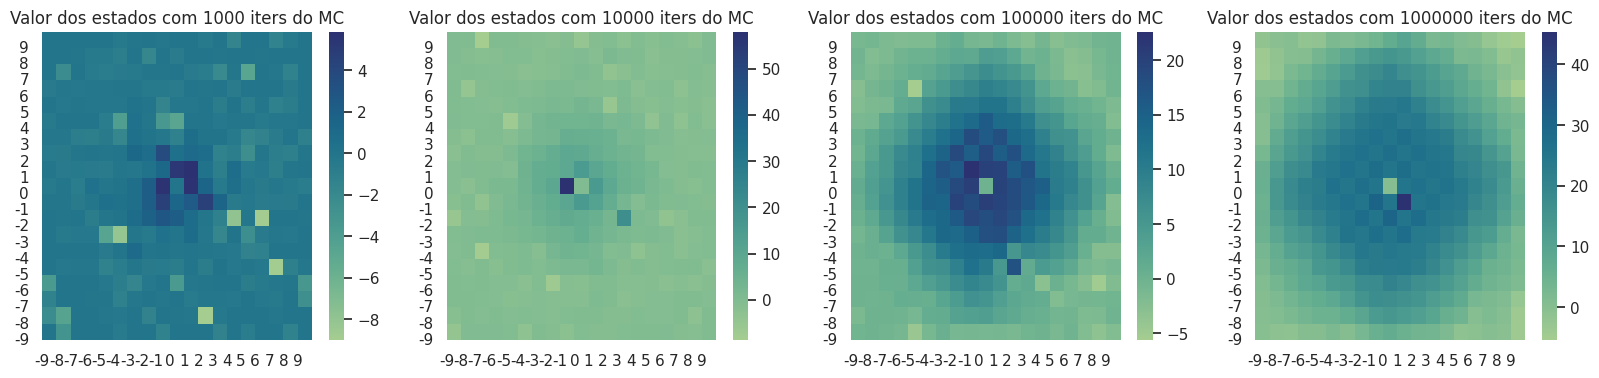

É possível observar que quanto mais o treinamento ocorre, melhor fica a aproximação para um valor ótimo, isto seria, onde os estados mais dintântes possuem valor mínimo e os estados mais centrais possuem valores maiores, considerante que o (0,0) é onde está a fruta, é onde deseja-se chegar.

Uma outra possível comparação a ser feita é saber quantos passos em média cada abordagem levaria para chegar na fruta. Os resultados montraram os seguintes valores (sendo a média de 1000 experimentos aleátórios) e comparados com a política aleatória e com uma regra ótima, criado por nós, que indica o melhor caminho possível sempre:

- Política aleatória: 239 passos em média
- Monte Carlo após 1 Milhão de iterações de treino: 70 passos em média
- Política ótima: 7 passos em média


Segundo nossos análises, o Monte Carlo atingiu o mesmo resultado na maioria dos experimentos, mas fica commédia maior por acabar caindo em loops e subindo a média, uma vez que consideramos a parada após 1000 passos sem chegar na fruta. As taxas de loops (ou episódios maiores que 1000) pode ser visto a seguir:

- Política aleatória: 3,7% de loops
- Monte Carlo após 1 Milhão de iterações de treino: 6,3% de loops
- Política ótima: sem loops


A fim de evitar Loops, fizemos um teste removendo a técnica $ϵ$-greedy na avaliação, e no lugar dela, adicionamos uma probabilidade de 1% de não seguir a política indicada pela função valor, mas sim escolher uma ação aleatória, evitando ficar preso em loops dessa forma.

O resultado foi uma redução para 0.1% de loops apenas e uma redução para 20.3 como tamanho médio do episódio. Mostrando assim que o método de Monte Carlo funcionou e perfoma de maneira bastante eficiente e conseguiu aprender a jogar no ambiente proposto.

### Avaliando o hiperparâmetro N0

A próxima análise a ser realizada se baseia no pararâmetro N0. Podemos ver a seguir um gráfico (em escala logarítimica no eixo x) da quantidade de loops ou episódios com mais de 1000 passos que ocorreram fixando o número de passos de treinamento do Monte Carlo como 10000 e função reward de -1 a cada passo do agente e 99 no caso de pegar a fruta/comida, ou seja, chegar no final do episódio, avaliando assim o efeito da variação do N0 entre 1, 10, 100, 1000, 1000. Já o segundo o gráfico segue a mesma configuranção mas mostra o número médio de passos até se chegar a fruta nas diferentes configurações.




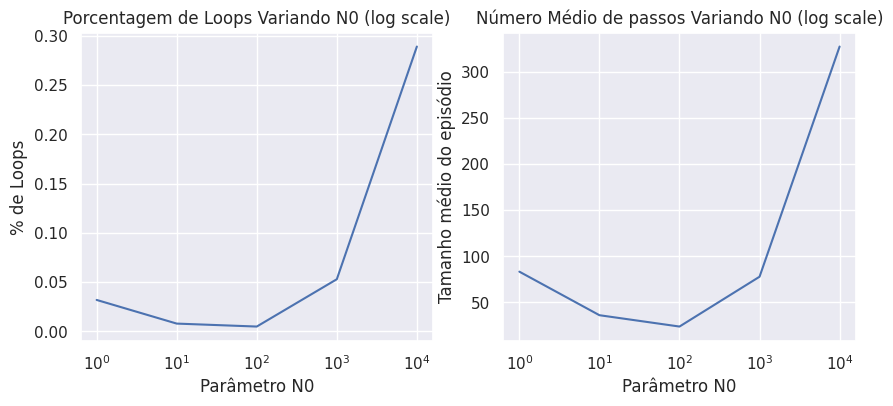

Para o nosso ambiente e nossas configurações coletadas, o que se mostrou mais eficaz foi o N0=100. Isso depende diretamente do problema sendo tratado, uma vez que o tamnho do npumero de estados pode influenciar muito nessa conta.

### Avaliando o ambiente estocástico

Para a avaliar o processo de aprendizado do agente em um ambiente estocático, foram realizados os seguintes exprimentos, fixando o N0=1000 do método ϵ-greedy e alterando o número de iterações de treino:

Para a avaliar a dificuldade no treino, de forma mais ampla, adiciona uma probabilidade de ação escolhida pelo a gente não se concretizar. De forma lúdica, pode ser visto como um "escorregão" ou um vento no agente durante a execução do episódio. Neste primeiro teste, qaulque lugar do tabuleiro pode ocorrer esses eventos aleatórios, abaixo estão mostrados os resultados para a probablidade de ocorrencia de 10%, 50% e 90% desses eventos aleatórios.

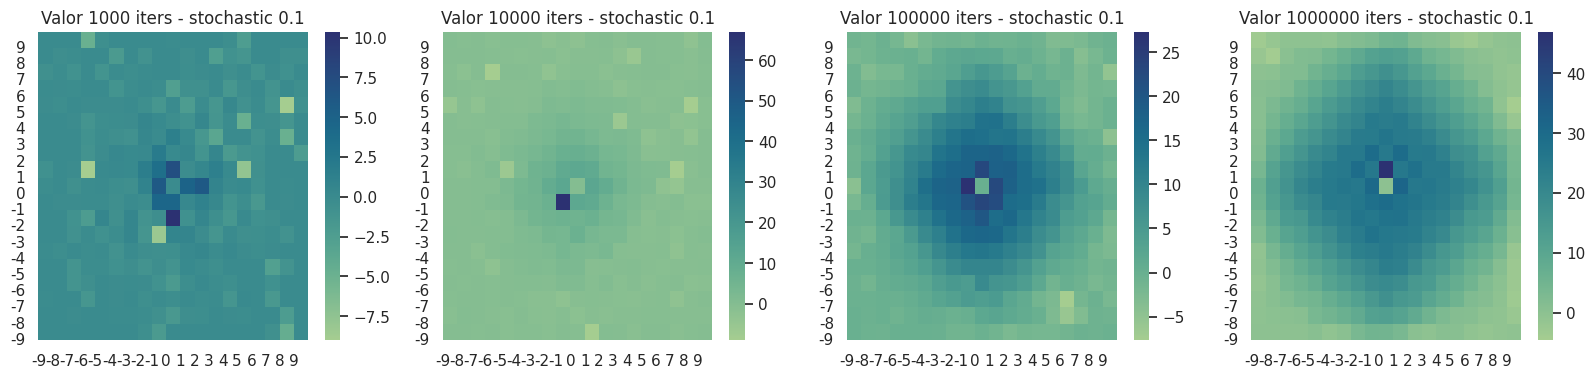

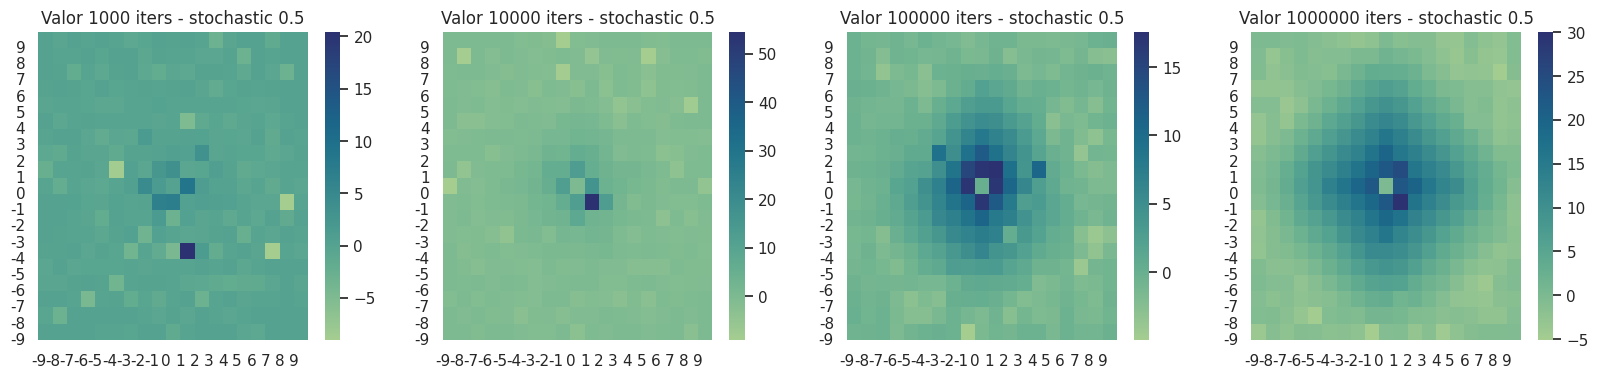

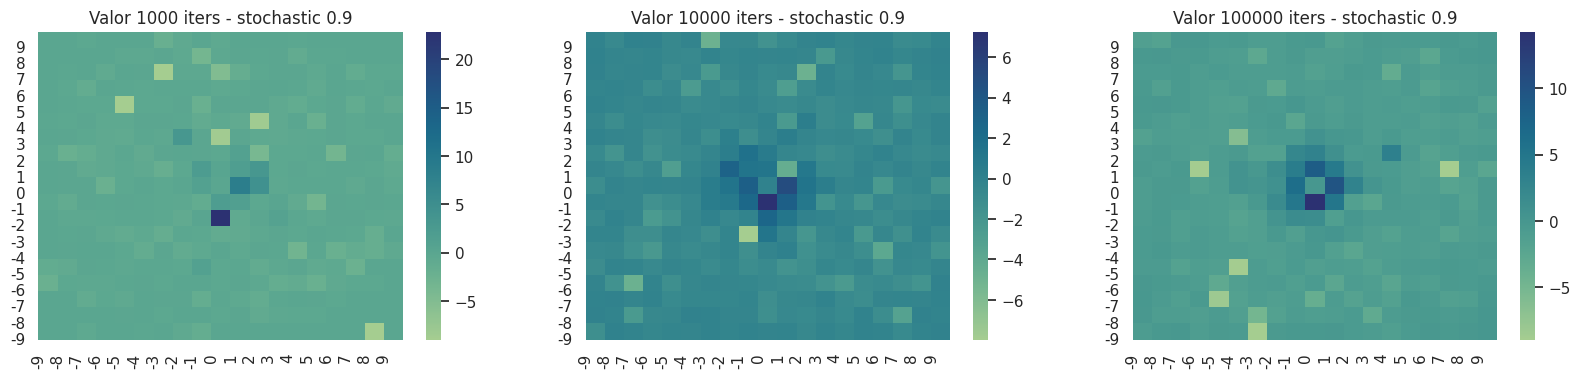

É possível notar, através da análise da uniformidade das cores dos estados representando o valor, nesses casos, a maior dificuldade de aprendizado do agente para ambientes mais estocáticos. Isso se deve por conta da dificuldade de atribuir o valor correto do estado no episódio, demandando mais iterações de treino para efetivamente conseguiur valorá-los.

A diferença nos maios numeros de iterações é evidente, uma vez que no ambiente menos estacástico a função valor ficou mais gradual e menos ruidosa, o agente aprendeu de forma muito mais lenta no caso de um ambiente mais estocástico.

### Avaliando a influencia do reward

Para avaliar a influencia da função reward, mostramos os gráficos abaixo. Nesse caso, usamos o N0=100 para o ϵ-grredy e um alpha dinâmico com requerido e todos foram rodados com 10mil iterações.

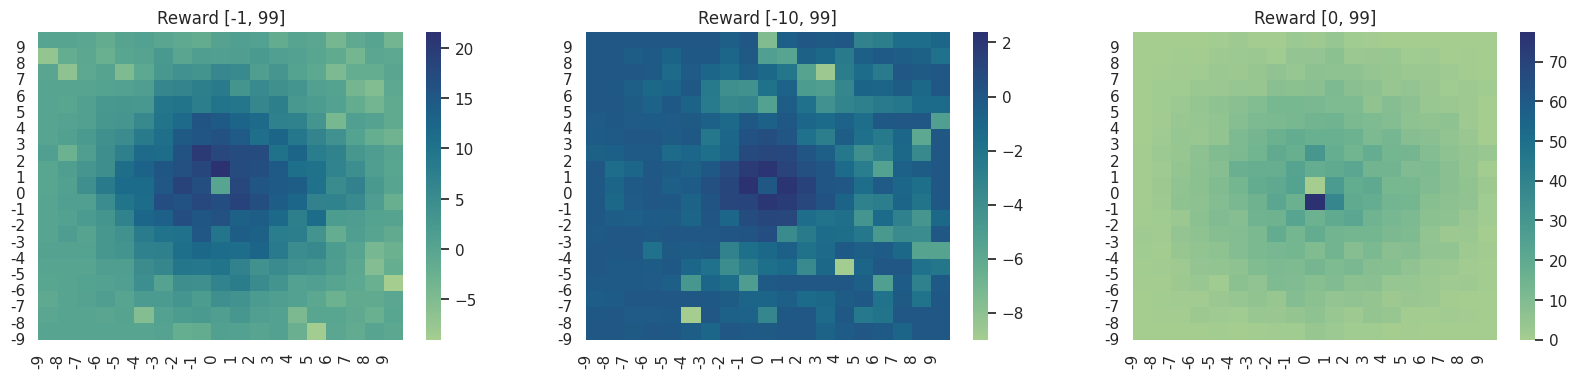

1) O primeiro deles mostra a função utilizada nos testes anteriores, que desconta um ponto a cada passo e adiciona 99 pontos ao conseguir o objetivo. Essa modelagem foi feita para que o agente evite desperdiçar passos, e por isso é punido enquanto anda, e que tente chegar o mais proximo da comida, e por isso é recompensado quando chega. Nesse caso, o tamnho médio do epsódio é 85 e a proporção de loops é de 6,8%

2) O segundo gráfico, mostra um aprendizado mal sucedido, por conta de uma penalização muito alta no andar do agente. Esse desbalanço evidencia a importanâcia do balanço desse reward, uma vez que a recopença no objetivo deve ser suficiente para valorar bem os estados. Nesse caso, o tamnho médio do epsódio é 800 e a proporção de loops é de 79%.

3) O terceiro gráfico mostra o oposto. Nesse caso, não há desconto ao andar, porém há o desconto temporal pelo fator γ da atualização, fazendo com que os estados ainda sejam de certa forma valorados e ainda haja aprendizado. Ou seja, recompensando menos os maiores episódios.  Nesse caso, o tamnho médio do epsódio é 20 e a proporção de loops é de 0,1%


Fica evidente então que um balanço entre a recompensa final e o desconto ao andar, ainda que seja somente pelo fator gamma, torna o aprendizado do agente mais efetivo.

Pórem, encontramos uma modelagem melhor para função reward, que faz com que o a gente aprenda de forma eficiente.

### Avaliando o Melhor que Encontramos

Utilizando todos os testes e informações anteriores, chegamos na melhores características para esse problema:

- O máximo de iterações possíveis, o resutado mostrado é para 100mil.
- N0 sendo 100.
- Função reward apenas com 99 de recompensa no final.


Treinamos um agente com as melhores características, os resultadas de: grafico da função valor, numero médio de passos no epsódio e proporção de loops e episódios maiores que 1000 podem ser vistos abaixo (para rodar, basta descomentar as células abaixo, demora ~1-2min).

- Tamanho médio de 8 à 20 passos por episódio, dependendo da simulação
- Proporção de loops inferior à 0.1%

A seguinte função valor:


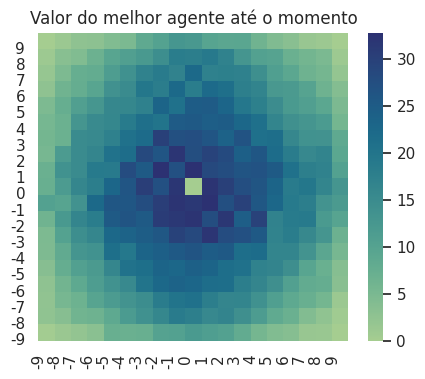

In [21]:
# game = SnakeGame()
# game.render()
# agent = MonteCarloAgent(game, reward_shape = [0,99])

# agent.run_Monte_Carlo(num_samples = 100000, N0 = 100, stochastic=False)
# value_function = agent.value_function

In [22]:
# test_method(method = 'value')

In [23]:
# plt.figure(figsize = (5,4))
# matrix_values = np.zeros((19, 19))
# for k in list(value_function.keys()):
#   x = int(k.split(',')[0].split('(')[1])
#   y = int(k.split(',')[1].split(')')[0])

#   matrix_values[x+9][y+9] = value_function[k]

# matrix_values[9][9] = 0

# a = sns.heatmap(matrix_values, cmap="crest")#, annot = True)
# a.invert_yaxis()
# plt.xticks(range(19))
# a.set_xticklabels([-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9])
# plt.yticks(range(19))
# a.set_yticklabels([-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9])
# plt.title(f'Valor do melhor agente até o momento')

In [23]:
def func_to_vectorize(x, y, dx, dy, scaling=0.01):
    plt.arrow(x, y, dx*scaling, dy*scaling, fc="k", ec="k", head_width=0.06, head_length=0.1)